# Section E. Bias-Variance Analysis
## Question 7 [Bias-Variance for Ridge Regression, 25 Marks]

In [1]:
# reading the data
read_data <- function(fname, sc) {
  data <- read.csv(file=fname,head=TRUE,sep=",")
  #data <- read.csv('assessments_datasets/Task2A.csv',head=TRUE,sep=",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr,1:(nc-1)]
  y = data[1:nr,nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return (list("x" = x, "y" = y))
}
options(warn = -1)

In [2]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
  return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
  # the L2 regulariser is already included in the objective function for training 
  return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
  n_weights = dim(W)[1]
  errors = matrix(,nrow=n_weights, ncol=2)
  for (tau in 1:n_weights) {
    errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
    errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
  }
  return(errors)
}
options(warn = -1)

In [3]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {
  
  train_len = dim(train_x)[1]
  tau_max = max_epoch * train_len
  
  W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
  W[1,] <- runif(ncol(train_x))
  
  tau = 1 # counter 
  obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
  obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
  
  while (tau <= tau_max){
    
    # check termination criteria
    if (obj_func_val[tau,1]<=epsilon) {break}
    
    # shuffle data:
    train_index <- sample(1:train_len, train_len, replace = FALSE)
    
    # loop over each datapoint
    for (i in train_index) {
        
      # increment the counter
      tau <- tau + 1
      if (tau > tau_max) {break}
      
      # make the weight update
      y_pred <- predict_func(train_x[i,], W[tau-1,])
      W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)
      
      # keep track of the objective funtion
      obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
    }
  }
  # resulting values for the training objective function as well as the weights
  return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
  # MODIFY THIS FUNCTION FOr L2 REG
  grad = - (y_true-y_pred) * x 
  return(W_prev - eta * (grad+lambda*W_prev))
}
options(warn = -1)

### Q7-1 Load Task2B_train.csv and Task2B_test.csv sets.

In [5]:
train<- read_data("assessments_datasets/Task2B_train.csv", TRUE)
test<- read_data("assessments_datasets/Task2B_test.csv", TRUE)

### SGD

In [30]:
N = nrow(train$x)
D = 100  # the number of samples in each selected dataset
L = 50 # number of datasets 
#M <- 7  # maximum degree of polynomials 
lambda<- (seq(1:26)-1)/5

# create training and testing sets
train.set <- seq(1,N,10) # training set (we choose every tenth point as training data)
train.N <- length(train) # number of samples in the trainin set
test.N <- nrow(test$x)       # number of testing samples

# create empty matrix to record result in each sampling iteration
y_sgd <- data.frame(matrix(0,nrow=L*length(lambda), ncol=test.N+2))
names(y_sgd) <- c('lambda', 'l',  paste('y',1:(test.N), sep=''))
y_sgd$lambda <- rep(lambda, each = L)
y_sgd$l <- rep(1:L, length(lambda), each = 1)
options(warn = -1)

In [31]:
for (l in 1:L){ # for each dataset..
    indx <- sample(train.set, D, replace = TRUE) # select D samles from the training set
    #print (indx)
    for (lam in (seq(1:26)-1)/5){
        train_res <- sgd_train(train$x[indx,], train$y[indx,], lam, 0.01, 0.001, 20)
        #predict <- train_res$W[nrow(train_res$W),] * test$x
        predict <- predict_func(test$x,matrix(train_res$W[nrow(train_res$W),]))
        y_sgd[y_sgd$lambda==lam & y_sgd$l==l, -c(1,2)] <- predict
    }
}
options(warn = -1)

In [32]:
match <- matrix(lambda,nrow=length(lambda))
y_sgd.bar <- aggregate(y_sgd, list(y_sgd$lambda),mean)
y_sgd.bar <- as.matrix(y_sgd.bar[,-c(1:3)])

error <- matrix(0,nrow=length(lambda))
bias2 <- matrix(0,nrow=length(lambda))
variance <- matrix(0,nrow=length(lambda))

for (idx in ((seq(1:26)-1)/5)){
    bias2[idx*5+1] <- mean((y_sgd.bar[idx*5+1,] - test$y)^2)
    variance[idx*5+1] <- mean((y_sgd[y_sgd$lambda==idx,-c(1,2)]-y_sgd.bar[idx*5+1,])^2)
    error[idx*5+1] <- mean((y_sgd[y_sgd$lambda==idx,-c(1,2)]-test$y)^2)
}

#for (idx in 1:nrow(match)){
#  bias2[idx] <- mean((y_sgd.bar[idx,] - test$y)^2)
#  variance[idx] <- mean((y_sgd[y_sgd$lambda==match[idx],-c(1,2)]-y_sgd.bar[idx,])^2)
#  error[idx] <- mean((y_sgd[y_sgd$lambda==match[idx],-c(1,2)]-test$y)^2)
#  }
options(warn = -1)

### PLot

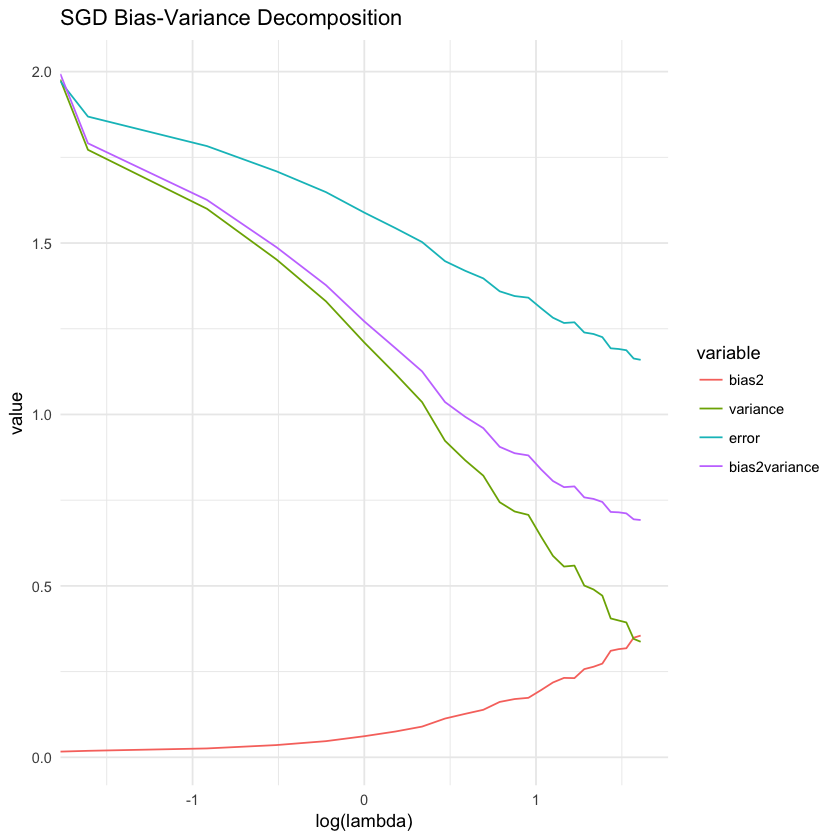

In [71]:
#plot these values.
library(ggplot2)
library(reshape2)
dat <- as.data.frame(cbind(lambda, bias2=bias2, variance, error, bias2+variance))
names(dat) <- c('lambda', 'bias2', 'variance', 'error', 'bias2variance')
dat.m <- melt(dat, id='lambda')
ggplot(data=dat.m, aes(x=log(lambda), y=value, color=variable)) + geom_line() + 
        labs(title='SGD Bias-Variance Decomposition') +  theme_minimal()

### Q7-4 Based on your plot in the previous part (Part III), what’s the best value for lambda? Explain your answer in terms of the bias, variance, and test error in your Jupyter Notebook file.

- The best value for lambda : 4.8 (log-lambda = 1.6)

Generalisation error = bias2 + variance. Bias represents the average prediction over all data sets differs from the desired regression function. Variance measures the solutions for individual data sets vary around their average. The goal is to minimize the generalisation error, which we have decomposed into the sum of a (squared) bias and a variance. There is a trade-off between bias and variance at lambda = 4.8. Small values of lambda, in the range 0 < lambda < 4.8, there is large variance (shown by the the green curves) but low bias (shown by the red curves). Two curves gradually intersect at a point the lambda = 4.8.
